<a href="https://colab.research.google.com/github/lealcastillo1996/Thesis_LLMs/blob/main/3_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install rouge_score
!pip install sentence_transformers

import nltk
nltk.download('punkt')
nltk.download('wordnet')

"""models and embeddings download"""


#Embeddings for context search
from sentence_transformers import SentenceTransformer, util
import torch
embedder = SentenceTransformer('all-MiniLM-L6-v2')



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Human labeling correlation with metrics


In [ ]:
import pandas as pd
df_human = pd.read_csv('df_answered_large_test1.csv', delimiter=';', skiprows=0, low_memory=False)

df_human = df_human.loc[df_human['Label']!= '-']
print(df_human['Label'].value_counts())



0    66
3    58
2    19
1    18
Name: Label, dtype: int64


In [ ]:
import pandas as pd
import re

# Assuming your DataFrame is named 'df'
# Define a function to remove digits using regex
def remove_digits(text):
    text = re.sub(r'\d+', '', text)
    text = re.sub(r' {2,}', ' ', text)
    return text.strip()




# Define a function to lowercase, remove numbers, and clean whitespace
def clean_text(column):
    try:
      #remove spaces and digits
      column = column.apply(remove_digits)
      # Lowercase the text
      column = column.str.lower()
      column = column.str.replace('*', '')
      column = column.str.replace('[', '')
      column = column.str.replace(']', '')
      column = column.str.replace('/n', '')
      column = column.str.replace('\n', '')
    except:
      pass




    return column

# Apply the clean_text function to each cell in the DataFrame
df_human['Answer']=  clean_text(df_human['Answer'])

# Apply the clean_text function to each cell in the DataFrame
df_human['Answer_generated']=  clean_text(df_human['Answer_generated'])


# Display the updated DataFrame
df_human





<ipython-input-47-32a314a9ab09>:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  column = column.str.replace('*', '')
<ipython-input-47-32a314a9ab09>:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  column = column.str.replace('[', '')
<ipython-input-47-32a314a9ab09>:23: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  column = column.str.replace(']', '')


,Question,Class,Answer,Answer_generated,Label
0,Define what is kubelet,Open Concept,the kubelet is a service agent which controls ...,kubelet is an agent that runs on each node in ...,3
1,What does GKE stands for?,Close,google kubernetes engine,"gke stands for ""google kubernetes engine"".",3
2,Consider a situation where a company desires t...,Situation,in order to give millions of clients the digit...,in order for this company to upgrade their dep...,3
3,Which mechanism within the control plane is ut...,Close,security profiles,the rbac (role-based access control) mechanism...,2
4,What are the distinct Kubernetes objects?,Multiple,"pods, deployments, services, configmaps, ingre...",deployment,1
...,...,...,...,...,...
156,Is the number of arguments specified by the co...,Close,no,"no, the number of arguments specified by the c...",3
157,What are the three modes of Pod Security Admis...,Multiple,"enforce, audit, warn",there are three modes of pod security admissio...,3
158,What are the distinct Kubernetes objects?,Multiple,"pods, deployments, services, configmaps, ingre...",podspods are the fundamental building blocks o...,0
159,Provide a catalog of the different services th...,Multiple,"cluster ip service, load balancer service, nod...",kubernetes service catalog,0


In [ ]:

import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate import meteor_score as meteor
from nltk.tokenize import word_tokenize
import collections

import string

dict_metrics= {}


df = df_human.copy()
#Dropping nan values
df.dropna(inplace=True)
#df = df.loc[df["Answer_generated"]!= ""]
#df = df.loc[df["Answer_generated"]!= " "]
df.reset_index(inplace=True, drop = True)

# Initialize lists to store scores
bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougeL_scores = []
meteor_scores = []
cosine_emb = []
f1_scores = []
exact_matches = []
mean_vals = []
# Calculate scores for each row
for i in range(len(df)):

    # Calculate ROUGE score
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = scorer.score(df['Answer'][i], df['Answer_generated'][i])
    rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
    rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
    rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

    # Calculate METEOR score

    # Tokenize and preprocess the sentences
    ref_tokens = nltk.word_tokenize(str(df['Answer'][i]).lower().translate(str.maketrans('', '', string.punctuation)))
    cand_tokens = nltk.word_tokenize(str(df['Answer_generated'][i]).lower().translate(str.maketrans('', '', string.punctuation)))

    # Compute the METEOR score
    meteor_score = meteor.meteor_score([ref_tokens], cand_tokens)
    meteor_scores.append(meteor_score)


    # Calculate BLEU score


    # Tokenize the sentences
    ref_tokens = nltk.word_tokenize(str(df['Answer'][i]).lower())
    cand_tokens = nltk.word_tokenize(str(df['Answer_generated'][i]).lower())

    bleu_score = sentence_bleu([ref_tokens], cand_tokens)
    bleu_scores.append(bleu_score)

    # Calculate exact match
    exact_match = int(df['Answer'][i] == df['Answer_generated'][i])
    exact_matches.append(exact_match)


    #Calculate embeddings cosine similarity
    ref_embeddings = embedder.encode(str(df['Answer'][i]).lower(), convert_to_tensor=True)
    cand_embeddings = embedder.encode(str(df['Answer_generated'][i]).lower(), convert_to_tensor=True)
    # We use cosine-similarity
    cos_scores = util.cos_sim(ref_embeddings, cand_embeddings)[0].tolist()[0]
    cosine_emb.append(cos_scores)


    #Calculate f1
    common = collections.Counter(ref_tokens) & collections.Counter(cand_tokens)
    num_same = sum(common.values())


    f1 = 0
    if num_same != 0:
      precision = num_same/ len(cand_tokens)
      recall =  num_same/ len(ref_tokens)
      f1 = (2 * precision * recall) / (precision + recall)
    f1_scores.append(f1)


    mean_vals.append((rouge_scores['rouge1'].fmeasure + rouge_scores['rouge2'].fmeasure + rouge_scores['rougeL'].fmeasure + meteor_score + bleu_score + exact_match +  cos_scores + f1)/ 8)

 # Add scores to dataframe
df['BLEU_score'] = bleu_scores
df['ROUGE1_score'] = rouge1_scores
df['ROUGE2_score'] = rouge2_scores
df['ROUGEL_score'] = rougeL_scores
df['METEOR_score'] = meteor_scores
df['Embeddings_similarity'] = cosine_emb
df['f1_score'] = f1_scores
df['exact_match'] = exact_matches
df["mean"] = mean_vals




/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [ ]:
df

,Question,Class,Answer,Answer_generated,Label,BLEU_score,ROUGE1_score,ROUGE2_score,ROUGEL_score,METEOR_score,Embeddings_similarity,f1_score,exact_match,mean
0,Define what is kubelet,Open Concept,the kubelet is a service agent which controls ...,kubelet is an agent that runs on each node in ...,3,3.407071e-02,0.302632,0.066667,0.144737,0.290179,0.864169,0.275449,0,0.247238
1,What does GKE stands for?,Close,google kubernetes engine,"gke stands for ""google kubernetes engine"".",3,4.034282e-78,0.666667,0.571429,0.666667,0.892256,0.616538,0.500000,0,0.489195
2,Consider a situation where a company desires t...,Situation,in order to give millions of clients the digit...,in order for this company to upgrade their dep...,3,1.028286e-78,0.312102,0.057692,0.140127,0.226337,0.760365,0.327684,0,0.228038
3,Which mechanism within the control plane is ut...,Close,security profiles,the rbac (role-based access control) mechanism...,2,5.691294e-232,0.020000,0.000000,0.020000,0.043478,0.407366,0.018692,0,0.063692
4,What are the distinct Kubernetes objects?,Multiple,"pods, deployments, services, configmaps, ingre...",deployment,1,0.000000e+00,0.285714,0.000000,0.285714,0.090909,0.353266,0.000000,0,0.126950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152,Is the number of arguments specified by the co...,Close,no,"no, the number of arguments specified by the c...",3,5.651352e-232,0.020833,0.000000,0.020833,0.048544,0.046020,0.018349,0,0.019322
153,What are the three modes of Pod Security Admis...,Multiple,"enforce, audit, warn",there are three modes of pod security admissio...,3,2.852668e-78,0.400000,0.000000,0.133333,0.384615,0.495555,0.476190,0,0.236212
154,What are the distinct Kubernetes objects?,Multiple,"pods, deployments, services, configmaps, ingre...",podspods are the fundamental building blocks o...,0,8.259886e-232,0.057143,0.000000,0.028571,0.085470,0.592962,0.073171,0,0.104665
155,Provide a catalog of the different services th...,Multiple,"cluster ip service, load balancer service, nod...",kubernetes service catalog,0,1.301729e-233,0.117647,0.000000,0.117647,0.038760,0.427559,0.100000,0,0.100202


In [ ]:
from imblearn.over_sampling import SMOTE

X = df.drop(['Label','Question', 'Answer' , 'Answer_generated','Class'], axis =1) # Assuming 'Label' is the target column
y = df['Label'].astype(int)



smote = SMOTE(random_state = 7)
X_balanced, y_balanced = smote.fit_resample(X, y)

df_balanced = pd.concat([X_balanced, y_balanced], axis=1)


df = df_balanced

print(df['Label'].value_counts())

3    62
2    62
1    62
0    62
Name: Label, dtype: int64


BLEU_score               0.282663
ROUGE1_score             0.444903
ROUGE2_score             0.413842
ROUGEL_score             0.384007
METEOR_score             0.538985
Embeddings_similarity    0.588671
f1_score                 0.436233
exact_match              0.228653
mean                     0.506144
Label                    1.000000
Name: Label, dtype: float64


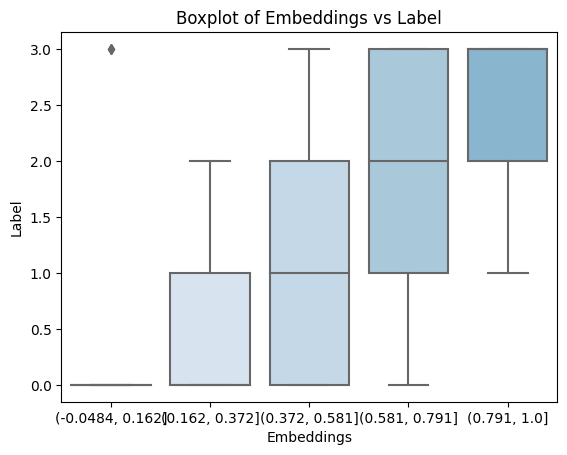

In [ ]:
#Checking correlation of labels and vars
print(df.corr()['Label'])
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define the number of bins
num_bins = 5

# Create the bins
x = pd.cut(df['Embeddings_similarity'], bins=num_bins)

# Define the y variable
y = df['Label']

# Create the boxplot
sns.boxplot(x=x, y=y)
plt.xlabel('Embeddings')
plt.ylabel('Label')
plt.title('Boxplot of Embeddings vs Label')
plt.show()




In [ ]:
# Linear regression with crossvalidation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

X =  df.drop(['Label','mean'], axis=1)
y = df['Label' ]

# Create a Linear Regression model
model =  RandomForestClassifier(max_depth=10, random_state=0)

# Perform cross-validation
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')



# Print the cross-validation scores
print('accuracy', scores)
print('accuracy', scores.mean())


accuracy [0.8        0.76       0.68       0.68       0.76       0.88
 0.72       0.92       0.75       0.83333333]
accuracy 0.7783333333333333


In [ ]:
#testing

from sklearn.model_selection import train_test_split

# Assuming you have features in X and the target variable in y

# Split the data into training and testing sets, stratified by y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
#model_reg = LogisticRegression().fit(X , y)
model_reg = RandomForestClassifier(max_depth=10, random_state=0).fit(X_train , y_train)

predictions = model_reg.predict(X_test)

df = X_test.copy()



df['predicted'] = predictions


df['Label'] = y_test

df['diference'] = df['Label'] - df['predicted']


x = df['Label']
y_df = df['predicted']

display (df)

print('Accuracy ', accuracy_score(df['Label'], df['predicted'] ))

cm = confusion_matrix(x, y_df, labels=model_reg.classes_)
cm


,BLEU_score,ROUGE1_score,ROUGE2_score,ROUGEL_score,METEOR_score,Embeddings_similarity,f1_score,exact_match,predicted,Label,diference
221,1.975045e-156,0.057628,0.009386,0.057628,0.050064,0.413463,0.043684,0,0,2,2
39,1.448850e-231,0.000000,0.000000,0.000000,0.000000,0.171397,0.400000,0,0,0,0
6,5.651352e-232,0.019802,0.000000,0.019802,0.044643,0.204573,0.018182,0,0,1,1
62,6.955142e-236,0.127660,0.000000,0.042553,0.026810,0.086291,0.083333,0,0,0,0
149,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.636928,0.000000,0,0,0,0
25,5.559392e-01,0.776596,0.752688,0.776596,0.660527,0.879421,0.775120,0,3,3,0
205,1.806480e-79,0.220056,0.005373,0.096830,0.157525,0.706599,0.160205,0,1,2,1
178,9.633070e-232,0.146292,0.000000,0.075709,0.085669,0.403211,0.145872,0,1,1,0
19,1.355814e-78,0.268293,0.065574,0.154472,0.242972,0.695075,0.297398,0,3,3,0
180,7.005666e-155,0.666667,0.500000,0.666667,0.646552,0.807336,0.723527,0,1,1,0


Accuracy  0.8


array([[13,  0,  0,  0],
       [ 3,  9,  0,  0],
       [ 3,  1,  7,  2],
       [ 0,  1,  0, 11]])

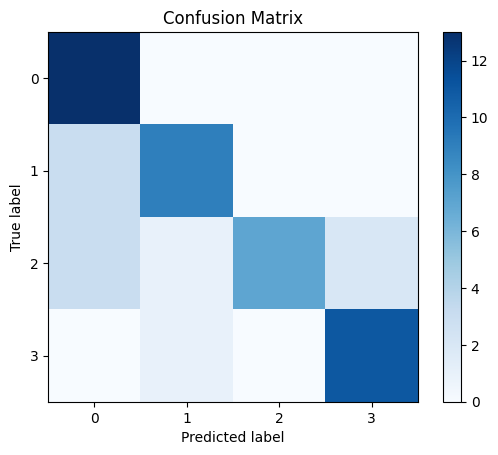

In [ ]:
labels = ['0', '1', '2','3']
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.savefig('con.png', dpi=300)

In [ ]:
#train4all
model_reg = RandomForestClassifier(max_depth=10, random_state=0).fit(X , y)

#Complete evaluation

In [ ]:
import pandas as pd
import re

# Assuming your DataFrame is named 'df'
# Define a function to remove digits using regex
def remove_digits(text):
    text = re.sub(r' {2,}', ' ', text)
    return text.strip()




# Define a function to lowercase, remove numbers, and clean whitespace
def clean_text(column):
    try:
      #remove spaces and digits
      column = column.apply(remove_digits)
      # Lowercase the text
      column = column.str.lower()
      column = column.str.replace('*', '')
      column = column.str.replace('[', '')
      column = column.str.replace(']', '')
      column = column.str.replace('/n', '')
      column = column.str.replace('\n', '')
    except:
      pass




    return column


In [ ]:
import pickle
#Load a dict
with open('saved_dictionary_openai.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

with open('saved_dictionary_roberta.pkl', 'rb') as f:
    loaded_dict_2 = pickle.load(f)

with open('saved_dictionary_t5.pkl', 'rb') as f:
    loaded_dict_3 = pickle.load(f)

with open('saved_dictionary_lora_full.pkl', 'rb') as f:
    loaded_dict_4 = pickle.load(f)


In [ ]:
#Change my error in the key name
updated_dict = {}
for key in loaded_dict.keys():
    new_key = key.replace("flant5", "openai")
    updated_dict[new_key] = loaded_dict[key]

loaded_dict=updated_dict


In [ ]:
'''
combined_dict = {**loaded_dict, **loaded_dict_2,**loaded_dict_3,**loaded_dict_4 }
#Code to append some of the dfs
import pandas as pd



keys_to_remove = []
for key, value in combined_dict.items():


    if "chunk_overlap:100" not in key:
        keys_to_remove.append(key)

    if "nosearch" in key:
        keys_to_remove.append(key)





    #Cleaning cols
    # Apply the clean_text function to each cell in the DataFrame
    combined_dict[key]['Answer']=  clean_text(combined_dict[key]['Answer'])

    # Apply the clean_text function to each cell in the DataFrame
    combined_dict[key]['Answer_generated']=  clean_text(combined_dict[key]['Answer_generated'])

    #Clean an answer
    combined_dict[key].loc[combined_dict[key]['Answer'] == 'no, the number of arguments specified by the configuration file for a pod is not fixed. it can vary depending on the specific requirements and needs of the application being deployed.', 'Answer'] = 'no'


for key in keys_to_remove:
  try:
    del combined_dict[key]
  except:
    pass






df_holder = pd.DataFrame()
for key in combined_dict:

  # Load the dataframe1
  df = combined_dict[key]
  df_holder = pd.concat([df_holder,df], axis=0 )
df_holder

print(len(df_holder))

#Making a stratified sample
from sklearn.model_selection import train_test_split


# Specify the column you want to use for stratification
stratify_column = df_holder['Class']

# Split the data into a stratified train and test set
X_train, X_test, y_train, y_test = train_test_split(df_holder, df_holder['Answer'], test_size=0.5, stratify=stratify_column, random_state = 77)


df_holder = X_train


df_holder.to_csv("df_answered_large.csv")
df_holder
'''


'\ncombined_dict = {**loaded_dict, **loaded_dict_2,**loaded_dict_3,**loaded_dict_4 }\n#Code to append some of the dfs\nimport pandas as pd\n\n\n\nkeys_to_remove = []\nfor key, value in combined_dict.items():\n\n\n    if "chunk_overlap:100" not in key:\n        keys_to_remove.append(key)\n\n    if "nosearch" in key:\n        keys_to_remove.append(key)\n\n\n\n\n\n    #Cleaning cols\n    # Apply the clean_text function to each cell in the DataFrame\n    combined_dict[key][\'Answer\']=  clean_text(combined_dict[key][\'Answer\'])\n\n    # Apply the clean_text function to each cell in the DataFrame\n    combined_dict[key][\'Answer_generated\']=  clean_text(combined_dict[key][\'Answer_generated\'])\n\n    #Clean an answer\n    combined_dict[key].loc[combined_dict[key][\'Answer\'] == \'no, the number of arguments specified by the configuration file for a pod is not fixed. it can vary depending on the specific requirements and needs of the application being deployed.\', \'Answer\'] = \'no\'\n\n

In [ ]:
combined_dict = {**loaded_dict, **loaded_dict_2,**loaded_dict_3,**loaded_dict_4 }




#FILTERING DICT
keys_to_remove = []
for key, value in combined_dict.items():


    if "chunk_overlap:100" not in key:
        keys_to_remove.append(key)

    if "nosearch" in key:
        keys_to_remove.append(key)





    #Cleaning cols
    # Apply the clean_text function to each cell in the DataFrame
    combined_dict[key]['Answer']=  clean_text(combined_dict[key]['Answer'])

    # Apply the clean_text function to each cell in the DataFrame
    combined_dict[key]['Answer_generated']=  clean_text(combined_dict[key]['Answer_generated'])

    #Clean an answer
    combined_dict[key].loc[combined_dict[key]['Answer'] == 'no, the number of arguments specified by the configuration file for a pod is not fixed. it can vary depending on the specific requirements and needs of the application being deployed.', 'Answer'] = 'no'


for key in keys_to_remove:
  try:
    del combined_dict[key]
  except:
    pass




<ipython-input-56-63731c507fa6>:20: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  column = column.str.replace('*', '')
<ipython-input-56-63731c507fa6>:21: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  column = column.str.replace('[', '')
<ipython-input-56-63731c507fa6>:22: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  column = column.str.replace(']', '')


In [ ]:
combined_dict['qa_flant5_search_emb chunk_size:4000 chunk_overlap:100 conntext_pages:1']

,Question,Answer,Class,Answer_generated
0,Is the number of arguments specified by the co...,no,Close,yes
1,What does GKE stands for?,google kubernetes engine,Close,google kubernetes engine
2,Which mechanism within the control plane is ut...,security profiles,Close,roles and rolebindings
3,How is called a non-terminating loop that regu...,control loop,Close,a control loop
4,Which specific command is capable of producing...,kubeadm certs generate-csr,Code Commands,kubeadm certs generate-csr --kubeconfig-dir /t...
5,Which command is utilized to display Persisten...,kubectl get pv --sort-by=.spec.capacity.storage,Code Commands,kubectl get pv task-pv-volume
6,Which command is utilized to retrieve the logs...,kubectl logs --since=1h,Code Commands,kubectl logs --since=1h
7,Why kubectl get rc --namespace=”<namespace_nam...,to list the replication controllers by namespace.,Code Commands,to get the rc for a specific namespace.
8,Provide a catalog of the different services th...,"cluster ip service, load balancer service, nod...",Multiple,the service catalog
9,What are the distinct Kubernetes objects?,"pods, deployments, services, configmaps, ingre...",Multiple,podspods are the fundamental building blocks o...


In [ ]:
import pandas as pd
import nltk
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate import meteor_score as meteor
from nltk.tokenize import word_tokenize
import collections

import string

dict_metrics= {}

#Calculate over each df in the dic
for key in combined_dict:

  # Load the dataframe
  df = combined_dict[key]


  # Initialize lists to store scores
  bleu_scores = []
  rouge1_scores = []
  rouge2_scores = []
  rougeL_scores = []
  meteor_scores = []
  cosine_emb = []
  f1_scores = []
  exact_matches = []
  pred = []


  # Calculate scores for each row
  for i in range(len(df)):

      # Calculate ROUGE score
      scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
      rouge_scores = scorer.score(df['Answer'][i], df['Answer_generated'][i])
      rouge1_scores.append(rouge_scores['rouge1'].fmeasure)
      rouge2_scores.append(rouge_scores['rouge2'].fmeasure)
      rougeL_scores.append(rouge_scores['rougeL'].fmeasure)

      # Calculate METEOR score

      # Tokenize and preprocess the sentences
      ref_tokens = nltk.word_tokenize(str(df['Answer'][i]).lower().translate(str.maketrans('', '', string.punctuation)))
      cand_tokens = nltk.word_tokenize(str(df['Answer_generated'][i]).lower().translate(str.maketrans('', '', string.punctuation)))

      # Compute the METEOR score
      meteor_score = meteor.meteor_score([ref_tokens], cand_tokens)
      meteor_scores.append(meteor_score)


      # Calculate BLEU score


      # Tokenize the sentences
      ref_tokens = nltk.word_tokenize(str(df['Answer'][i]).lower())
      cand_tokens = nltk.word_tokenize(str(df['Answer_generated'][i]).lower())

      bleu_score = sentence_bleu([ref_tokens], cand_tokens)
      bleu_scores.append(bleu_score)

      # Calculate exact match
      exact_match = int(df['Answer'][i] == df['Answer_generated'][i])
      exact_matches.append(exact_match)


      #Calculate embeddings cosine similarity
      ref_embeddings = embedder.encode(str(df['Answer'][i]).lower(), convert_to_tensor=True)
      cand_embeddings = embedder.encode(str(df['Answer_generated'][i]).lower(), convert_to_tensor=True)
      # We use cosine-similarity
      cos_scores = util.cos_sim(ref_embeddings, cand_embeddings)[0].tolist()[0]
      cosine_emb.append(cos_scores)


      #Calculate f1
      common = collections.Counter(ref_tokens) & collections.Counter(cand_tokens)
      num_same = sum(common.values())


      f1 = 0
      if num_same != 0:
        precision = num_same/ len(cand_tokens)
        recall =  num_same/ len(ref_tokens)
        f1 = (2 * precision * recall) / (precision + recall)
      f1_scores.append(f1)



      #Predicted class
      mini_df = pd.DataFrame({'BLEU_score':[bleu_score], 'ROUGE1_score': [rouge_scores['rouge1'].fmeasure] , 'ROUGE2_score': [rouge_scores['rouge2'].fmeasure] , 'ROUGEL_score':[rouge_scores['rougeL'].fmeasure] ,'METEOR_score':[meteor_score],'Embeddings_similarity':[cos_scores],'f1_score': [f1],'exact_match': [exact_match]})
      X = mini_df
      pred.append( model_reg.predict(X))



  # Add scores to dataframe
  df['BLEU_score'] = bleu_scores
  df['ROUGE1_score'] = rouge1_scores
  df['ROUGE2_score'] = rouge2_scores
  df['ROUGEL_score'] = rougeL_scores
  df['METEOR_score'] = meteor_scores
  df['Embeddings_similarity'] = cosine_emb
  df['f1_score'] = f1_scores
  df['exact_match'] = exact_matches
  df["predicted"] = pred


  # save the dataframe
  dict_metrics[key] = df


Streaming output truncated to the last 5000 lines.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently 

In [ ]:

#Save dict to load directly
import pickle
with open('metrics.pkl', 'wb') as f:
  pickle.dump(dict_metrics, f)


In [ ]:
"""

!pip install rouge_score
import nltk
nltk.download('punkt')
nltk.download('wordnet')
import pickle
import numpy as np
from matplotlib import pyplot as plt


#Load a dict
with open('metrics.pkl', 'rb') as f:
  dict_metrics = pickle.load(f)


"""

"\n\n!pip install rouge_score\nimport nltk\nnltk.download('punkt')\nnltk.download('wordnet')\nimport pickle\nimport numpy as np\nfrom matplotlib import pyplot as plt\n\n\n#Load a dict\nwith open('metrics.pkl', 'rb') as f:\n  dict_metrics = pickle.load(f)\n\n\n"

In [ ]:
dict_metrics['qa_gpt4all_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:5']

,Question,Answer,Class,Answer_generated,BLEU_score,ROUGE1_score,ROUGE2_score,ROUGEL_score,METEOR_score,Embeddings_similarity,f1_score,exact_match,predicted
0,Is the number of arguments specified by the co...,no,Close,"no, the number of arguments specified by theco...",7.919884e-232,0.076923,0.000000,0.076923,0.147059,0.061917,0.068966,0,[0]
1,What does GKE stands for?,google kubernetes engine,Close,"gke stands for ""google container engine"".",1.250850e-231,0.444444,0.000000,0.444444,0.303030,0.474079,0.333333,0,[1]
2,Which mechanism within the control plane is ut...,security profiles,Close,the mechanism used to impose particular config...,9.109160e-232,0.117647,0.000000,0.117647,0.151515,0.328286,0.111111,0,[0]
3,How is called a non-terminating loop that regu...,control loop,Close,"in kubernetes, a control loop is a non-termina...",4.241304e-155,0.210526,0.117647,0.210526,0.294118,0.574221,0.200000,0,[3]
4,Which command is utilized to display Persisten...,kubectl get pv --sort-by=.spec.capacity.storage,Code Commands,the command to sort persistentvolumes based on...,1.051835e-231,0.333333,0.090909,0.333333,0.100000,0.706419,0.173913,0,[1]
5,Which command is utilized to retrieve the logs...,kubectl logs --since=1h,Code Commands,"the correct response is ""kubectl logs --since=...",1.933853e-01,0.571429,0.500000,0.571429,0.841270,0.827965,0.470588,0,[2]
6,Why kubectl get rc --namespace=”<namespace_nam...,to list the replication controllers by namespace.,Code Commands,the `kubectl` command line interface allows us...,3.033076e-155,0.151899,0.025974,0.126582,0.318201,0.637475,0.141414,0,[3]
7,What are the three modes of Pod Security Admis...,"enforce, audit, warn",Multiple,1. warn - this mode generates warnings but doe...,7.586831e-232,0.048780,0.000000,0.032520,0.101351,0.474162,0.057971,0,[3]
8,Name the initial namespaces from which Kuberne...,"default, kube-system, kube-public",Multiple,the initial namespaces from which kubernetes s...,1.218332e-231,0.526316,0.352941,0.526316,0.655271,0.795302,0.320000,0,[1]
9,What is Kubernetes?,kubernetes is an open-source container orchest...,Open Concept,kubernetes is an open-source system for automa...,1.205377e-01,0.383562,0.166667,0.287671,0.160906,0.900263,0.353659,0,[2]


In [ ]:
#Cleaning

for key, df in dict_metrics.items():
  #Dropping nan values
  dict_metrics[key].dropna(inplace=True)
  dict_metrics[key] = dict_metrics[key].loc[dict_metrics[key]["Answer_generated"]!= ""]
  dict_metrics[key] = dict_metrics[key].loc[df["Answer_generated"]!= " "]
  dict_metrics[key].reset_index(inplace=True, drop = True)
  dict_metrics[key].loc[dict_metrics[key]['Class'] == 'Open proccess', 'Class'] = 'Open Proccess'
  dict_metrics[key].loc[dict_metrics[key]['Class'] == 'Open Proccess', 'Class'] = 'Open Process'


# Results All models

In [ ]:
#Calculate over each df in the dic

model_name = []
score = []

# Step 1: Calculate average mean for each DataFrame
mean_dict = {}
for key, df in dict_metrics.items():
    average_mean = df['predicted'].mean()  # Replace 'column_name' with the desired column
    mean_dict[key] = average_mean

# Step 2: Sort the dictionary based on average mean values
sorted_dict = dict(sorted(mean_dict.items(), key=lambda x: x[1], reverse=True))

# Step 3: Retrieve the ranked list of DataFrames and print the mean value
for key in sorted_dict.keys():
    print(f"DataFrame: {key} | Average Mean: {sorted_dict[key]}")
    model_name.append(key)
    score.append(sorted_dict[key])



DataFrame: qa_openai_search_emb chunk_size:2000 chunk_overlap:100 conntext_pages:3 | Average Mean: [2.82142857]
DataFrame: qa_openai_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:10 | Average Mean: [2.75]
DataFrame: qa_openai_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:1 | Average Mean: [2.75]
DataFrame: qa_openai_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:5 | Average Mean: [2.71428571]
DataFrame: qa_openai_search_emb chunk_size:8000 chunk_overlap:100 conntext_pages:1 | Average Mean: [2.64285714]
DataFrame: qa_openai_search_emb chunk_size:2000 chunk_overlap:100 conntext_pages:1 | Average Mean: [2.57142857]
DataFrame: qa_openai_search_emb chunk_size:2000 chunk_overlap:100 conntext_pages:5 | Average Mean: [2.53571429]
DataFrame: qa_openai_search_emb chunk_size:4000 chunk_overlap:100 conntext_pages:3 | Average Mean: [2.46428571]
DataFrame: qa_openai_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:3 | Average Mean: [2.46428571]
Dat

In [ ]:
pd.DataFrame({"Model - Context combination":model_name ,"Mean estimated human label score":score })

,Model - Context combination,Mean estimated human label score
0,qa_openai_search_emb chunk_size:2000 chunk_ove...,[2.8214285714285716]
1,qa_openai_search_emb chunk_size:1000 chunk_ove...,[2.75]
2,qa_openai_search_emb chunk_size:1000 chunk_ove...,[2.75]
3,qa_openai_search_emb chunk_size:1000 chunk_ove...,[2.7142857142857144]
4,qa_openai_search_emb chunk_size:8000 chunk_ove...,[2.642857142857143]
5,qa_openai_search_emb chunk_size:2000 chunk_ove...,[2.5714285714285716]
6,qa_openai_search_emb chunk_size:2000 chunk_ove...,[2.5357142857142856]
7,qa_openai_search_emb chunk_size:4000 chunk_ove...,[2.4642857142857144]
8,qa_openai_search_emb chunk_size:1000 chunk_ove...,[2.4642857142857144]
9,qa_openai_search_emb chunk_size:4000 chunk_ove...,[2.357142857142857]


Average for roberta:  0.4714285714285714
Average for gpt4all:  1.4165054727880815
Average for flant5:  1.3071428571428572
Average for openai:  2.607142857142857


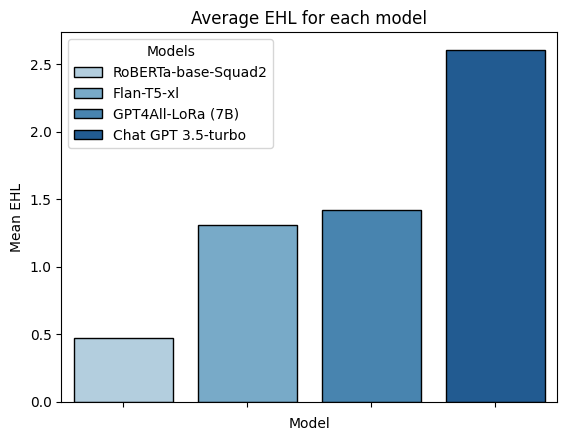

In [ ]:
#Results by model
# importing mean()
from statistics import mean

roberta_list = []
openai_list = []
gpt4all_list = []
flant5_list = []

# Step 1: Calculate average for search and no search

for key, df in dict_metrics.items():
  average_mean = df['predicted'].mean()
  if "roberta" in key:
    roberta_list.append(average_mean)
  elif "gpt4all" in key:
    gpt4all_list.append(average_mean)
  elif "flant5" in key:
    flant5_list.append(average_mean)
  else:
    openai_list.append(average_mean)

print("Average for roberta: ", np.mean(roberta_list))
print("Average for gpt4all: ", np.mean(gpt4all_list))
print("Average for flant5: ", np.mean(flant5_list))
print("Average for openai: ", np.mean(openai_list))


# Assuming you have the following average values
roberta_average = np.mean(roberta_list)
gpt4all_average = np.mean(gpt4all_list)
flant5_average = np.mean(flant5_list)
openai_average = np.mean(openai_list)

# Create a list of labels for the x-axis
labels = ['RoBERTa-base-Squad2', 'Flan-T5-xl', 'GPT4All-LoRa (7B)', 'Chat GPT 3.5-turbo']


# Create a list of average values
averages = [roberta_average, flant5_average, gpt4all_average, openai_average]


data = pd.DataFrame(list(zip(labels, averages)), columns=['Models', 'Average'])



palette = sns.color_palette("Blues", n_colors=5)
subset_palette = palette[1:]

# Create a bar chart
barplot = sns.barplot(x='Models', y='Average', hue='Models', data=data, palette=subset_palette, edgecolor='black', dodge=False)

# Remove x-axis and y-axis labels
barplot.set_xticklabels([])


# Add labels and title
plt.xlabel('Model')
plt.ylabel('Mean EHL')
plt.title('Average EHL for each model')

# Display the chart
plt.savefig('aver.png', dpi=300)
plt.show()

In [ ]:
#Results by chunk size
# importing mean()
from statistics import mean

c8000_list = []
c4000_list = []
c2000_list = []
c1000_list = []

# Step 1: Calculate average for search and no search

for key, df in dict_metrics.items():
  average_mean = df['predicted'].mean()
  if "chunk_size:8000" in key:
    c8000_list.append(average_mean)
  elif "chunk_size:4000" in key:
    c4000_list.append(average_mean)
  elif "chunk_size:2000" in key:
    c2000_list.append(average_mean)
  else:
    c1000_list.append(average_mean)

print("Average for chunk size 8000: ", np.mean(c8000_list))
print("Average for chunk size 4000: ", np.mean(c4000_list))
print("Average for chunk size 2000: ", np.mean(c2000_list))
print("Average for chunk size 1000: ", np.mean(c1000_list))

Average for chunk size 8000:  1.275974025974026
Average for chunk size 4000:  1.2828027950310559
Average for chunk size 2000:  1.5155654761904762
Average for chunk size 1000:  1.529318337912088


In [ ]:
#Results by context page numbers.
# importing mean()
from statistics import mean

c8000_list = []
c4000_list = []
c2000_list = []
c1000_list = []

# Step 1: Calculate average for search and no search

for key, df in dict_metrics.items():
  average_mean = df['predicted'].mean()
  if "conntext_pages:10" in key:
    c8000_list.append(average_mean)
  elif "conntext_pages:5" in key:
    c4000_list.append(average_mean)
  elif "conntext_pages:3" in key:
    c2000_list.append(average_mean)
  else:
    c1000_list.append(average_mean)

print("Average for 10 chunks: ", np.mean(c8000_list))
print("Average for 5 chunks: ", np.mean(c4000_list))
print("Average for 3 chunks: ", np.mean(c2000_list))
print("Average for 1 chunk: ", np.mean(c1000_list))

Average for 10 chunks:  1.3727678571428572
Average for 5 chunks:  1.5435267857142856
Average for 3 chunks:  1.4395238095238099
Average for 1 chunk:  1.4317891347782652


In [ ]:
#Add context size (chunks time pages)
sizes_dict = dict_metrics.copy()

import re
for key, df in dict_metrics.items():
  # Use regular expressions to find the chunk size pattern
  pattern = r"chunk_size:(\d+)"
  match = re.search(pattern, key)

  chunk_size = int(match.group(1))


  #extract number of context pages as int
  pattern = r"conntext_pages:(\d+)"
  match = re.search(pattern, key)

  chunk_pages = int(match.group(1))

  total_size = chunk_size * chunk_pages

  new_key = key + " size:"+  str(total_size)



  sizes_dict[new_key] = sizes_dict[key]
  del sizes_dict[key]



In [ ]:
#Results by context size (chunks time pages)
# importing mean()
from statistics import mean
s12000_list = []
s10000_list = []
s8000_list = []
s6000_list = []
s5000_list = []
s4000_list = []
s3000_list = []
s2000_list = []
s1000_list = []

# Step 1: Calculate average for search and no search

for key, df in   sizes_dict.items():
  average_mean = df['predicted'].mean()
  if "size:8000" in key:
    s8000_list.append(average_mean)
  elif "size:10000" in key:
    s10000_list.append(average_mean)
  elif "size:12000" in key:
    s12000_list.append(average_mean)
  elif "size:6000" in key:
    s6000_list.append(average_mean)
  elif "size:5000" in key:
    s5000_list.append(average_mean)
  elif "size:4000" in key:
    s4000_list.append(average_mean)
  elif "size:3000" in key:
    s3000_list.append(average_mean)
  elif "size:2000" in key:
    s2000_list.append(average_mean)
  elif "size:1000" in key:
    s1000_list.append(average_mean)




print("Average for total context size 12000: ", np.mean(s12000_list))
print("Average for total context size 10000: ", np.mean(s10000_list))
print("Average for total context size 8000: ", np.mean(s8000_list))
print("Average for total context size 6000: ", np.mean(s6000_list))
print("Average for total context size 5000: ", np.mean(s5000_list))
print("Average for total context size 4000: ", np.mean(s4000_list))
print("Average for total context size 3000: ", np.mean(s3000_list))
print("Average for total context size 2000: ", np.mean(s2000_list))
print("Average for total context size 1000: ", np.mean(s1000_list))


Average for total context size 12000:  1.125
Average for total context size 10000:  1.4084821428571428
Average for total context size 8000:  1.275974025974026
Average for total context size 6000:  1.6042857142857145
Average for total context size 5000:  1.6428571428571428
Average for total context size 4000:  1.440605590062112
Average for total context size 3000:  1.5892857142857144
Average for total context size 2000:  1.498214285714286
Average for total context size 1000:  1.5123626373626373


#Results for each model

In [ ]:
model_name = ["openai", "roberta", "flant5", "gpt4all"]
#Calculate over each df in the dic

for model in model_name:
  print(model)

  # Step 1: Calculate average mean for each DataFrame
  mean_dict = {}
  complete_dict = {}
  for key, df in dict_metrics.items():
      if model in key:
        average_mean = df['predicted'].mean()  # Replace 'column_name' with the desired column
        mean_dict[key] = average_mean
        complete_dict[key] = (len(df['predicted'])/28) * 100

  # Step 2: Sort the dictionary based on average mean values
  sorted_dict = dict(sorted(mean_dict.items(), key=lambda x: x[1], reverse=True))

  # Step 3: Retrieve the ranked list of DataFrames and print the mean value
  for key in sorted_dict.keys():
      print(f"DataFrame: {key} | Average Mean: {sorted_dict[key]}", '% of questions answered', complete_dict[key])




  print("-------------")



openai
DataFrame: qa_openai_search_emb chunk_size:2000 chunk_overlap:100 conntext_pages:3 | Average Mean: [2.82142857] % of questions answered 100.0
DataFrame: qa_openai_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:10 | Average Mean: [2.75] % of questions answered 100.0
DataFrame: qa_openai_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:1 | Average Mean: [2.75] % of questions answered 100.0
DataFrame: qa_openai_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:5 | Average Mean: [2.71428571] % of questions answered 100.0
DataFrame: qa_openai_search_emb chunk_size:8000 chunk_overlap:100 conntext_pages:1 | Average Mean: [2.64285714] % of questions answered 100.0
DataFrame: qa_openai_search_emb chunk_size:2000 chunk_overlap:100 conntext_pages:1 | Average Mean: [2.57142857] % of questions answered 100.0
DataFrame: qa_openai_search_emb chunk_size:2000 chunk_overlap:100 conntext_pages:5 | Average Mean: [2.53571429] % of questions answered 100.0
DataFrame:

In [ ]:
pd.DataFrame(combined_dict['roberta_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:5'].Answer_generated)

,Answer_generated
0,two
1,google kubernetes engine
2,profiles
3,a control loop
4,kubeadm certs generate-csrthis
5,:kubectl
6,kubectl logs
7,no namespace was provided in the command
8,kubernetes service catalog
9,"estring,uid, and optionalnamespacespec"


In [ ]:
from statistics import mean


models_dict_size={}



model_name = ["openai", "roberta", "flant5", "gpt4all"]
#Calculate over each df in the dic

for model in model_name:

  nosearch_list = []
  search_list = []

  c8000_list = []
  c4000_list = []
  c2000_list = []
  c1000_list = []


  n10_list = []
  n5_list = []
  n3_list = []
  n1_list = []


  s12000_list = []
  s10000_list = []
  s8000_list = []
  s6000_list = []
  s5000_list = []
  s4000_list = []
  s3000_list = []
  s2000_list = []
  s1000_list = []


  print(model)

  # Step 1: Calculate average mean for each DataFrame
  mean_dict = {}

  for key, df in sizes_dict.items():
    if model in key:
      average_mean = df['predicted'].mean()
      if "nosearch" in key:
        nosearch_list.append(average_mean)
      else:
        search_list.append(average_mean)

      average_mean = df['predicted'].mean()
      if "chunk_size:8000" in key:
        c8000_list.append(average_mean)
      elif "chunk_size:4000" in key:
        c4000_list.append(average_mean)
      elif "chunk_size:2000" in key:
       c2000_list.append(average_mean)
      else:
       c1000_list.append(average_mean)


      average_mean = df['predicted'].mean()
      if "conntext_pages:10" in key:
        n10_list.append(average_mean)
      elif "conntext_pages:5" in key:
        n5_list.append(average_mean)
      elif "conntext_pages:3" in key:
        n3_list.append(average_mean)
      else:
        n1_list.append(average_mean)


      average_mean = df['predicted'].mean()
      if "size:8000" in key:
        s8000_list.append(average_mean)
      elif "size:10000" in key:
        s10000_list.append(average_mean)
      elif "size:12000" in key:
        s12000_list.append(average_mean)
      elif "size:6000" in key:
        s6000_list.append(average_mean)
      elif "size:5000" in key:
        s5000_list.append(average_mean)
      elif "size:4000" in key:
        s4000_list.append(average_mean)
      elif "size:3000" in key:
        s3000_list.append(average_mean)
      elif "size:2000" in key:
        s2000_list.append(average_mean)
      elif "size:1000" in key:
        s1000_list.append(average_mean)











  print("Average for chunk size 8000: ", np.mean(c8000_list))
  print("Average for chunk size 4000: ", np.mean(c4000_list))
  print("Average for chunk size 2000: ", np.mean(c2000_list))
  print("Average for chunk size 1000: ", np.mean(c1000_list))
  try:
    print("Average for 10 chunks: ", np.mean(n10_list))
  except:
    print("10 chunks not available")
  print("Average for 5 chunks: ", np.mean(n5_list))
  print("Average for 3 chunks: ", np.mean(n3_list))
  print("Average for 1 chunk: ", np.mean(n1_list))

  try:
    print("Average for total context size 12000: ", np.mean(s12000_list))
  except:
    print("12k size not available")

  try:
    print("Average for total context size 10000: ", np.mean(s10000_list))
  except:
    print("10k size not available")


  print("Average for total context size 8000: ", np.mean(s8000_list))
  print("Average for total context size 6000: ", np.mean(s6000_list))
  print("Average for total context size 5000: ", np.mean(s5000_list))
  print("Average for total context size 4000: ", np.mean(s4000_list))
  print("Average for total context size 3000: ", np.mean(s3000_list))
  print("Average for total context size 2000: ", np.mean(s2000_list))
  print("Average for total context size 1000: ", np.mean(s1000_list))


  models_dict_size[model] = [np.mean(s1000_list), np.mean(s2000_list), np.mean(s3000_list), np.mean(s4000_list), np.mean(s5000_list), np.mean(s6000_list), np.mean(s8000_list), np.mean(s10000_list), np.mean(s12000_list)]


print("-------------")

openai
Average for chunk size 8000:  2.642857142857143
Average for chunk size 4000:  2.4107142857142856
Average for chunk size 2000:  2.642857142857143
Average for chunk size 1000:  2.669642857142857
Average for 10 chunks:  2.75
Average for 5 chunks:  2.625
Average for 3 chunks:  2.5833333333333335
Average for 1 chunk:  2.580357142857143
Average for total context size 12000:  2.4642857142857144
Average for total context size 10000:  2.642857142857143
Average for total context size 8000:  2.642857142857143
Average for total context size 6000:  2.8214285714285716
Average for total context size 5000:  2.7142857142857144
Average for total context size 4000:  2.357142857142857
Average for total context size 3000:  2.4642857142857144
Average for total context size 2000:  2.5714285714285716
Average for total context size 1000:  2.75
roberta
Average for chunk size 8000:  0.2857142857142857
Average for chunk size 4000:  0.3392857142857143
Average for chunk size 2000:  0.5
Average for chunk size

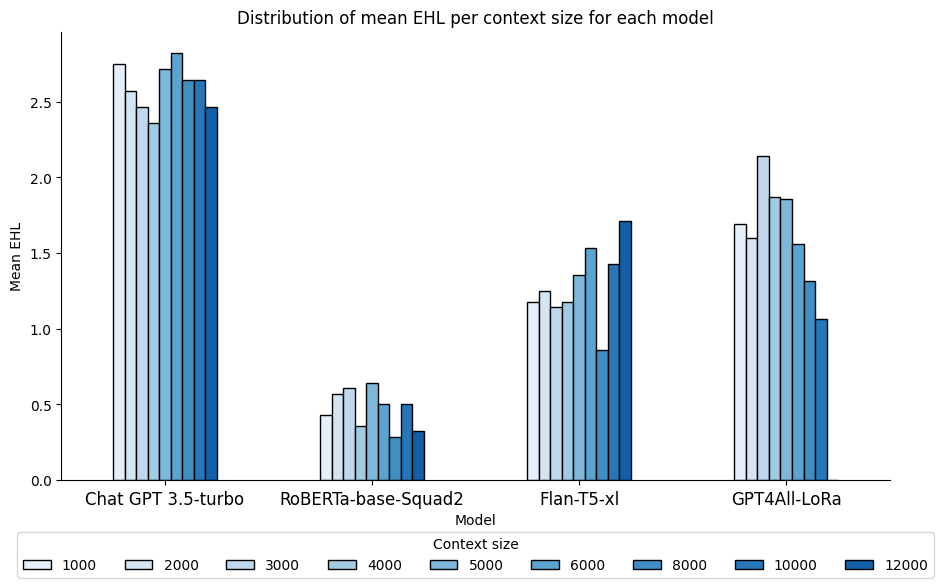

In [ ]:

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Create DataFrame from dictionary
df_size = pd.DataFrame.from_dict(models_dict_size)

rep = {'openai': 'Chat GPT 3.5-turbo', 'roberta': 'RoBERTa-base-Squad2', 'flant5': 'Flan-T5-xl', 'gpt4all': 'GPT4All-LoRa'}

df_size.rename(columns=rep, inplace=True)
# Transpose the DataFrame to have keys as columns
df_size = df_size.transpose()

df_size.reset_index(inplace=True)
# Set column names
df_size.columns = ['model', '1000', '2000', '3000', '4000', '5000', '6000', '8000', '10000', '12000']

# Set the model column as the index
df_size.set_index('model', inplace=True)

# Set the color palette
palette = sns.color_palette("Blues", n_colors=10)
subset_palette = palette[1:]
sns.set_palette(palette)
# Remove the top and right spines

# Plot the bar chart
ax = df_size.plot(kind='bar', figsize=(10, 6), edgecolor='black')
plt.xlabel('Model')
plt.ylabel('Mean EHL')
plt.title('Distribution of mean EHL per context size for each model')

# Adjust the font size and rotation of the x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12, rotation=0)

# Move the legend outside the plot
ax.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=10, title='Context size')

# Remove y-grid
ax.xaxis.grid(False)
sns.despine()

plt.tight_layout()
plt.savefig('dis.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
%load_ext google.colab.data_table
df_format = dict_metrics['qa_flant5_search_emb chunk_size:2000 chunk_overlap:100 conntext_pages:3']
df_format

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,Question,Answer,Class,Answer_generated,BLEU_score,ROUGE1_score,ROUGE2_score,ROUGEL_score,METEOR_score,Embeddings_similarity,f1_score,exact_match,predicted
0,Is the number of arguments specified by the co...,no,Close,no,1.821832e-231,1.000000,0.000000,1.000000,0.500000,1.000000,1.000000,1,[3]
1,What does GKE stands for?,google kubernetes engine,Close,google kubernetes engine,1.221339e-77,1.000000,1.000000,1.000000,0.981481,1.000000,1.000000,1,[3]
2,Which mechanism within the control plane is ut...,security profiles,Close,validating admission webhook,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.212330,0.000000,0,[0]
3,How is called a non-terminating loop that regu...,control loop,Close,a control loop,1.133423e-154,0.800000,0.666667,0.800000,0.892857,0.936188,0.800000,0,[3]
4,Which specific command is capable of producing...,kubeadm certs generate-csr,Code Commands,kubeadm certs generate-csr,1.221339e-77,1.000000,1.000000,1.000000,0.981481,1.000000,1.000000,1,[3]
5,Which command is utilized to display Persisten...,kubectl get pv --sort-by=.spec.capacity.storage,Code Commands,kubectl get pv --sort-by .spec.capacity.storage,5.081327e-01,1.000000,1.000000,1.000000,0.718157,0.991327,0.727273,0,[3]
6,Which command is utilized to retrieve the logs...,kubectl logs --since=1h,Code Commands,kubectl logs --since=1h,1.000000e+00,1.000000,1.000000,1.000000,0.981481,1.000000,1.000000,1,[3]
7,Why kubectl get rc --namespace=”<namespace_nam...,to list the replication controllers by namespace.,Code Commands,to set the namespace for a current request,1.425661e-231,0.400000,0.000000,0.400000,0.211268,0.280612,0.375000,0,[1]
8,Provide a catalog of the different services th...,"cluster ip service, load balancer service, nod...",Multiple,as a customer you’ll visit the website and cho...,1.218332e-231,0.187500,0.000000,0.125000,0.103448,0.372583,0.216216,0,[0]
9,What are the distinct Kubernetes objects?,"pods, deployments, services, configmaps, ingre...",Multiple,pods,8.271104e-236,0.285714,0.000000,0.285714,0.090909,0.622662,0.166667,0,[1]


question type Close
OpenAI AVG:  2.175
roberta AVG:  1.375
FlanT5 AVG:  1.6
GPT4All: AVG [1.49074074]
--------------


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


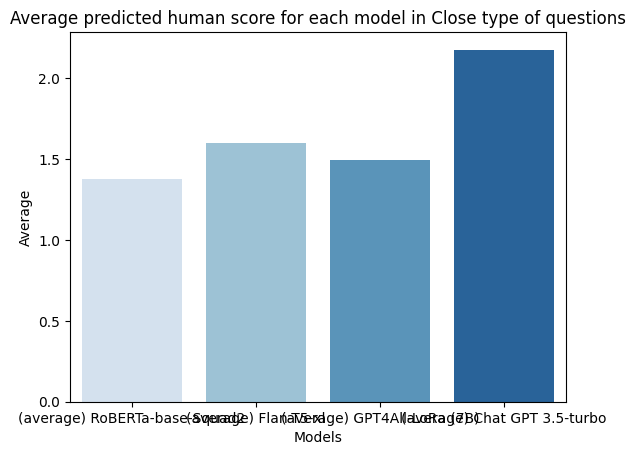

question type Code Commands
OpenAI AVG:  2.8
roberta AVG:  0.85
FlanT5 AVG:  2.075
GPT4All: AVG [1.79166667]
--------------


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


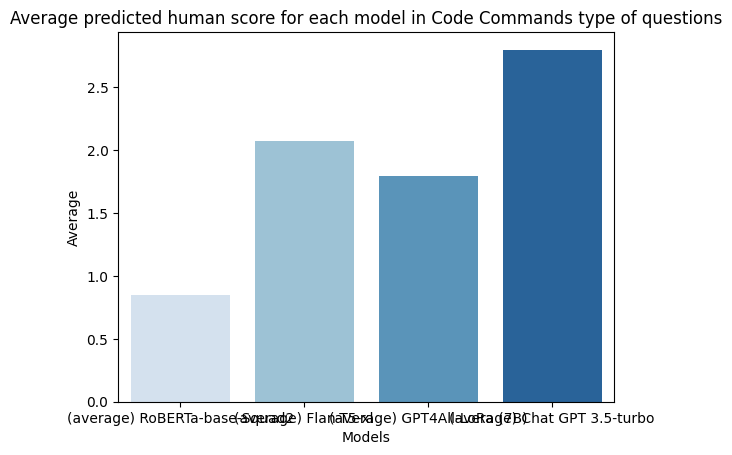

question type Multiple
OpenAI AVG:  2.45
roberta AVG:  0.025
FlanT5 AVG:  0.85
GPT4All: AVG 1.0583333333333331
--------------


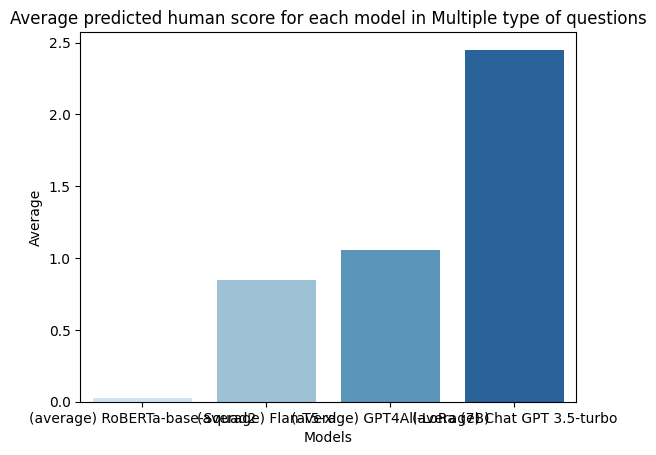

question type Open Concept
OpenAI AVG:  2.9
roberta AVG:  0.525
FlanT5 AVG:  0.875
GPT4All: AVG [1.42592593]
--------------


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


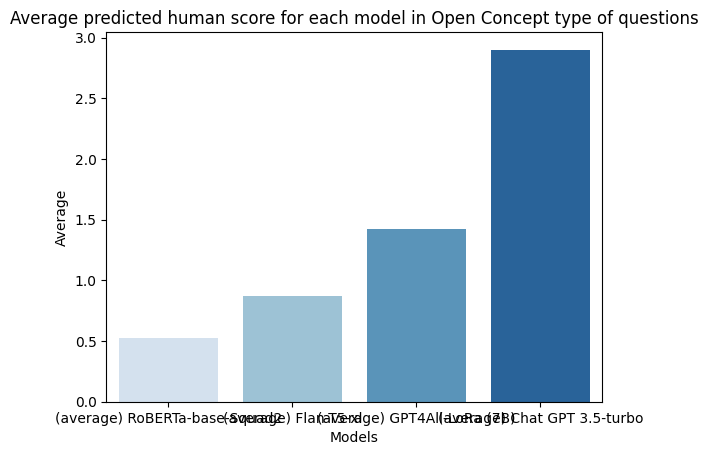

question type Situation
OpenAI AVG:  2.65
roberta AVG:  0.175
FlanT5 AVG:  0.95
GPT4All: AVG [2.0462963]
--------------


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


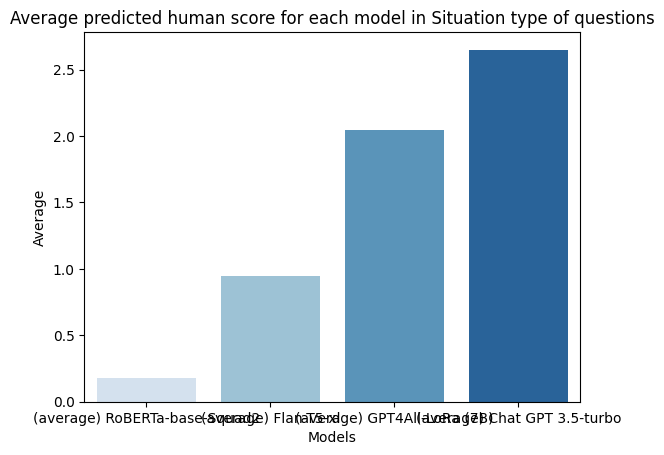

question type Comparison
OpenAI AVG:  2.875
roberta AVG:  0.2
FlanT5 AVG:  1.5
GPT4All: AVG [1.73148148]
--------------


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


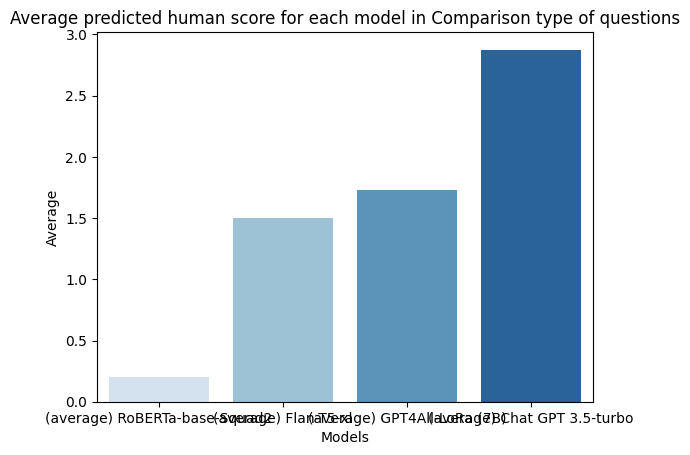

question type Open Process
OpenAI AVG:  2.4
roberta AVG:  0.15
FlanT5 AVG:  1.3
GPT4All: AVG [1.02777778]
--------------


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)


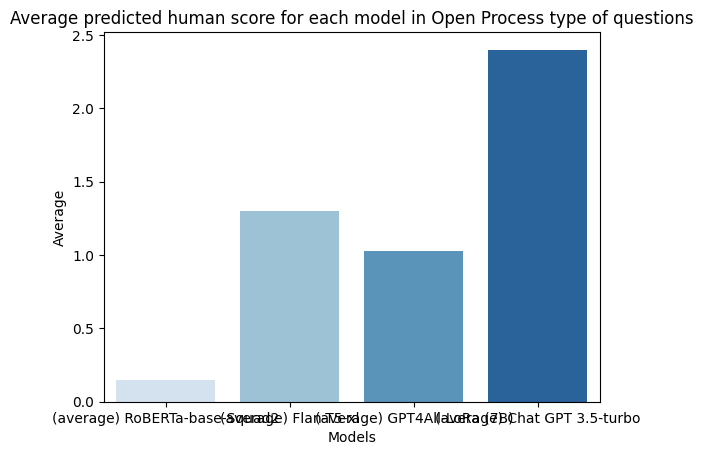

In [ ]:
#Cumulative df
df_results = pd.DataFrame()

#by type of question for each model
import seaborn as sns
model_name =['Roberta', 'Flant5', 'GPT4All', 'OpenAI']
types_question = df_format['Class'].unique()

#Calculate over each df in the dic
for question in types_question:


  for model in model_name:

    openai_list = []
    roberta_list = []
    flant5_list=[]
    gpt4all_list = []


    for key, df in sizes_dict.items():
      # Filter the DataFrame based on the specific class
      filtered_df = df[df['Class'] == question]

      # Calculate the mean of the filtered DataFrame
      average_mean  = filtered_df['predicted'].mean()
      if "openai" in key:
        openai_list.append(average_mean)
      elif "roberta" in key:
        roberta_list.append(average_mean )
      elif "flant5" in key:
        flant5_list.append(average_mean )
      elif "gpt4all" in key:
        gpt4all_list.append(average_mean )


  print('question type', question)
  print("OpenAI AVG: ", np.nanmean(openai_list))
  print("roberta AVG: ", np.nanmean(roberta_list ))
  print("FlanT5 AVG: ", np.nanmean(flant5_list))
  print("GPT4All: AVG", np.nanmean(gpt4all_list))
  print('--------------')

  # Assuming you have the following average values
  roberta_average =np.nanmean(roberta_list)
  gpt4all_average = np.nanmean(gpt4all_list)
  flant5_average = np.nanmean(flant5_list)
  openai_average =np.nanmean(openai_list)


  if isinstance(gpt4all_average, np.ndarray):
    # Assign the first element to var
    gpt4all_average = gpt4all_average[0]

  # Create a list of labels for the x-axis
  labels = ['(average) RoBERTa-base-Squad2', '(average) Flan-T5-xl', '(average) GPT4All-LoRa (7B)', '(average) Chat GPT 3.5-turbo']

  # Create a list of average values
  averages = [roberta_average,flant5_average,gpt4all_average, openai_average]

  # Create a pandas DataFrame from the averages and labels
  data = pd.DataFrame(list(zip(labels, averages)), columns=['Models', 'Average'])
  data['Type'] = question
  df_results = pd.concat([df_results , data],axis = 0)
  # Create a barplot
  try:
    sns.barplot(x='Models', y='Average', data=data, palette="Blues")
  except:
    pass


  # Set the title
  plt.title('Average predicted human score for each model in ' + question + ' type of questions')

  # Display the chart
  plt.show()





In [ ]:
df_results

,Models,Average,Type
0,(average) RoBERTa-base-Squad2,1.375000,Close
1,(average) Flan-T5-xl,1.600000,Close
2,(average) GPT4All-LoRa (7B),1.490741,Close
3,(average) Chat GPT 3.5-turbo,2.175000,Close
0,(average) RoBERTa-base-Squad2,0.850000,Code Commands
1,(average) Flan-T5-xl,2.075000,Code Commands
2,(average) GPT4All-LoRa (7B),1.791667,Code Commands
3,(average) Chat GPT 3.5-turbo,2.800000,Code Commands
0,(average) RoBERTa-base-Squad2,0.025000,Multiple
1,(average) Flan-T5-xl,0.850000,Multiple


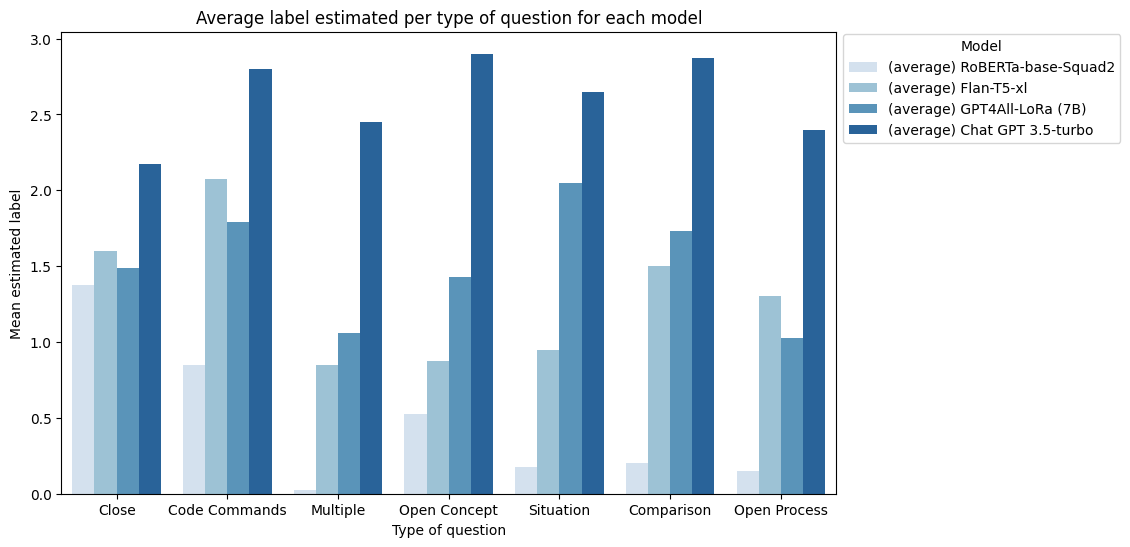

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x='Type', y='Average', hue='Models', dodge=0.5,palette="Blues")

# Set the title and labels
plt.title('Average label estimated per type of question for each model')
plt.xlabel('Type of question')
plt.ylabel('Mean estimated label')
# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1, 1.01), loc='upper left',title='Model')
# Display the plot
plt.show()


#The best possible from each model

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = np.asanyarray(a)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you m

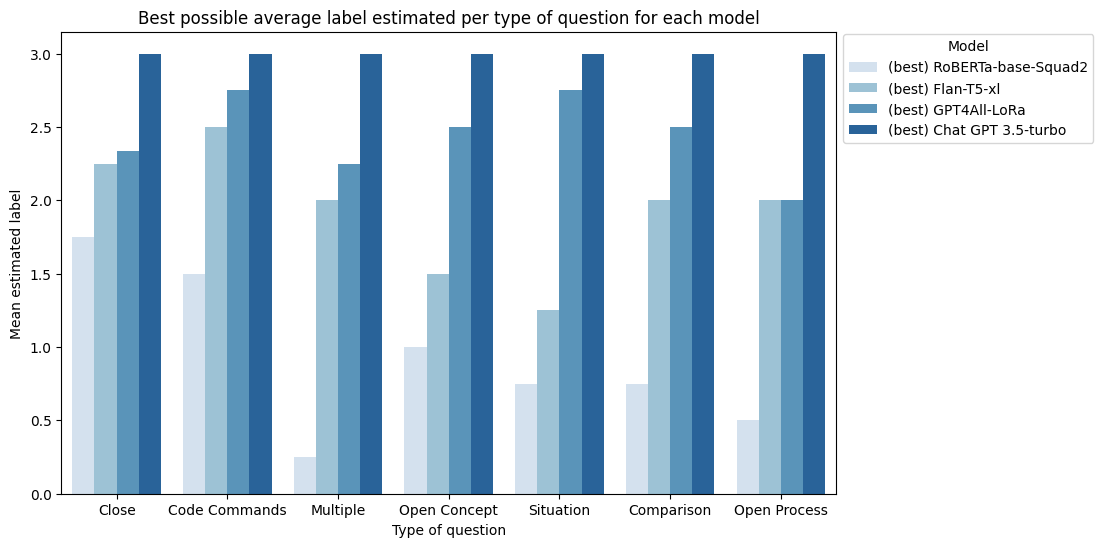

In [ ]:
#Cumulative df
df_results_max = pd.DataFrame()

#by type of question for each model
import seaborn as sns
model_name =['Roberta', 'Flant5', 'GPT4All', 'OpenAI']
types_question = df_format['Class'].unique()

#Calculate over each df in the dic
for question in types_question:


  for model in model_name:

    openai_list = []
    roberta_list = []
    flant5_list=[]
    gpt4all_list = []


    for key, df in sizes_dict.items():
      # Filter the DataFrame based on the specific class
      filtered_df = df[df['Class'] == question]

      # Calculate the mean of the filtered DataFrame
      average_mean  = filtered_df['predicted'].mean()
      if "openai" in key:
        openai_list.append(average_mean)
      elif "roberta" in key:
        roberta_list.append(average_mean )
      elif "flant5" in key:
        flant5_list.append(average_mean )
      elif "gpt4all" in key:
        gpt4all_list.append(average_mean )




  # Assuming you have the following average values
  roberta_average =np.nanmax(roberta_list)
  gpt4all_average = np.nanmax(gpt4all_list)
  flant5_average = np.nanmax(flant5_list)
  openai_average =np.nanmax(openai_list)


  if isinstance(gpt4all_average, np.ndarray):
    # Assign the first element to var
    gpt4all_average = gpt4all_average[0]

  # Create a list of labels for the x-axis
  labels = ['(best) RoBERTa-base-Squad2', '(best) Flan-T5-xl', '(best) GPT4All-LoRa', '(best) Chat GPT 3.5-turbo']

  # Create a list of average values
  averages = [roberta_average,flant5_average,gpt4all_average, openai_average]

  # Create a pandas DataFrame from the averages and labels
  data = pd.DataFrame(list(zip(labels, averages)), columns=['Models', 'Average'])
  data['Type'] = question
  df_results_max = pd.concat([df_results_max , data],axis = 0)


plt.figure(figsize=(10, 6))
sns.barplot(data=df_results_max, x='Type', y='Average', hue='Models', dodge=0.5,palette="Blues")

# Set the title and labels
plt.title('Best possible average label estimated per type of question for each model')
plt.xlabel('Type of question')
plt.ylabel('Mean estimated label')
plt.legend(bbox_to_anchor=(1, 1.01), loc='upper left',title='Model')
# Display the plot
plt.show()

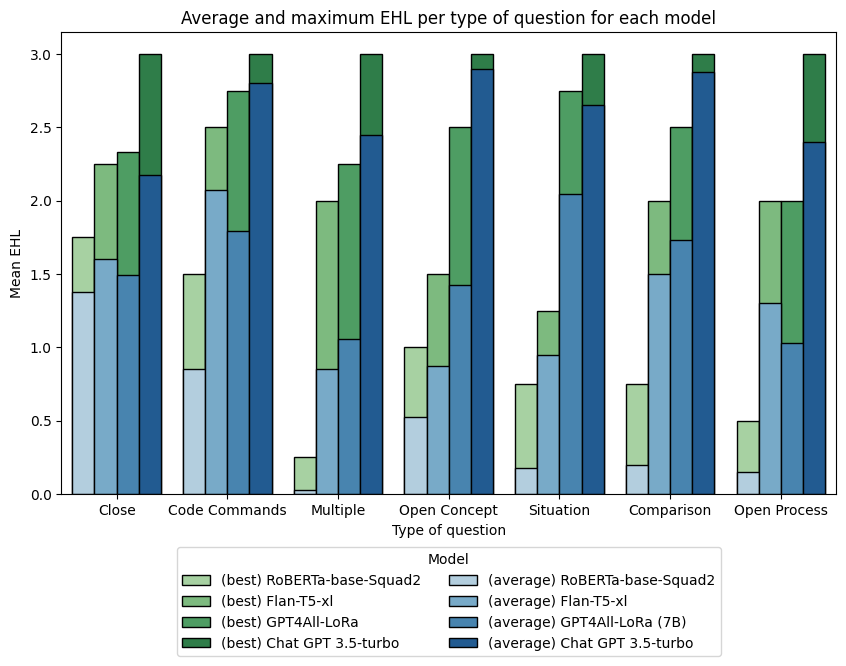

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

palette = sns.color_palette("Greens", n_colors=7)
subset_palette = palette[2:]

# Second plot: maximum values
sns.barplot(data=df_results_max, x='Type', y='Average', hue='Models', palette=subset_palette, linewidth=1, alpha=1, edgecolor='black')

palette = sns.color_palette("Blues", n_colors=5)
subset_palette = palette[1:]
# First plot: barplot
sns.barplot(data=df_results, x='Type', y='Average', hue='Models', dodge=0.5, palette=subset_palette, linewidth=1, edgecolor='black')

# Set the title and labels
plt.title('Average and maximum EHL per type of question for each model')
plt.xlabel('Type of question')
plt.ylabel('Mean EHL')

# Move the legend outside the plot and adjust its properties
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2, title='Model')

plt.savefig('types.png', dpi=300, bbox_inches='tight')
# Display the plot
plt.show()





#Just take into account best model

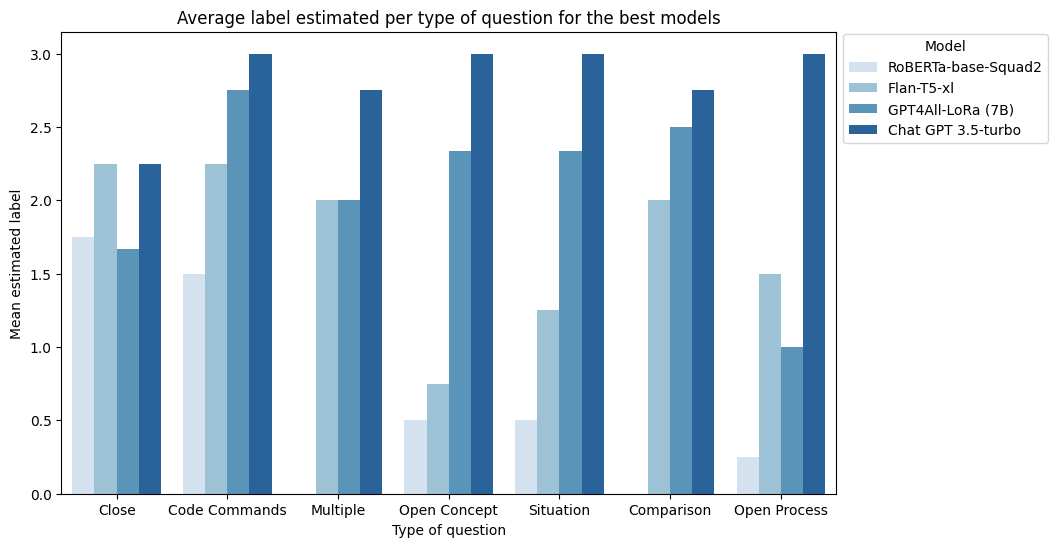

In [ ]:
selected_models = ['qa_openai_search_emb chunk_size:2000 chunk_overlap:100 conntext_pages:3', 'roberta_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:5','qa_flant5_search_emb chunk_size:4000 chunk_overlap:100 conntext_pages:3','qa_gpt4all_search_emb chunk_size:1000 chunk_overlap:100 conntext_pages:3']

def create_dictionary_with_keys(original_dict, key_list):
    new_dict = {}
    for key in key_list:
        if key in original_dict:
            new_dict[key] = original_dict[key]
    return new_dict


new_dict=create_dictionary_with_keys( dict_metrics, selected_models)










#Cumulative df
df_results = pd.DataFrame()

#by type of question for each model
import seaborn as sns
model_name =['Roberta', 'Flant5', 'GPT4All', 'OpenAI']
types_question = df_format['Class'].unique()

#Calculate over each df in the dic
for question in types_question:


  for model in model_name:

    openai_list = []
    roberta_list = []
    flant5_list=[]
    gpt4all_list = []


    for key, df in new_dict.items():
      # Filter the DataFrame based on the specific class
      filtered_df = df[df['Class'] == question]

      # Calculate the mean of the filtered DataFrame
      average_mean  = filtered_df['predicted'].mean()
      if "openai" in key:
        openai_list.append(average_mean)
      elif "roberta" in key:
        roberta_list.append(average_mean )
      elif "flant5" in key:
        flant5_list.append(average_mean )
      elif "gpt4all" in key:
        gpt4all_list.append(average_mean )



  # Assuming you have the following average values
  roberta_average =np.nanmean(roberta_list)
  gpt4all_average = np.nanmean(gpt4all_list)
  flant5_average = np.nanmean(flant5_list)
  openai_average =np.nanmean(openai_list)


  if isinstance(gpt4all_average, np.ndarray):
    # Assign the first element to var
    gpt4all_average = gpt4all_average[0]

  # Create a list of labels for the x-axis
  labels = ['RoBERTa-base-Squad2', 'Flan-T5-xl', 'GPT4All-LoRa (7B)', 'Chat GPT 3.5-turbo']

  # Create a list of average values
  averages = [roberta_average,flant5_average,gpt4all_average, openai_average]

  # Create a pandas DataFrame from the averages and labels
  data = pd.DataFrame(list(zip(labels, averages)), columns=['Models', 'Average'])
  data['Type'] = question
  df_results = pd.concat([df_results , data],axis = 0)


plt.figure(figsize=(10, 6))
sns.barplot(data=df_results, x='Type', y='Average', hue='Models', dodge=0.5,palette="Blues")

# Set the title and labels
plt.title('Average label estimated per type of question for the best models')
plt.xlabel('Type of question')
plt.ylabel('Mean estimated label')
plt.legend(bbox_to_anchor=(1, 1.01), loc='upper left',title='Model')
# Display the plot
plt.show()


